<a href="https://colab.research.google.com/github/codestates/ds-section4-sprint3/blob/master/ds_N431_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://user-images.githubusercontent.com/6457691/90080969-0f758d00-dd47-11ea-8191-fa12fd2054a7.png' width = '200' align = 'right'>

## *DATA SCIENCE / SECTION 4 / SPRINT 3 / NOTE 1*

---





# N431. Convolutional Neural Networks

# Warm Up
- Motive 영상 보기 : [목차외우기](https://youtu.be/WK86DrI-guw?t=32)
- 기존 노트 다시 보기
  * [ ] N421. 신경망과 퍼셉트론
  * [ ] N422. 역전파(Backpropagation, backward pass)
  * [ ] N423. 신경망 구현을 위한 프레임워크 + 학습규제(regularization) 전략
  * [ ] N424. 신경망의 파라미터 튜닝, 실험추적 시스템
- 개념정리를 위한 학습 나만의 목차 만들어보기
  * [ ] 목차제작 (아래 리스트 참조)
    * 전처리 : 데이터 정규화(min-max 등), 학습/검증 데이터 분류(data split), Batch 구성설정, 인코딩(Word2Vec 등)
    * Layers : Flatten, Dense(Fully Connected), Activation(sigmoid, ReLU, Softmax), BatchNorm, DropOut, **Convolution(New), Pooling(New)**
    * 가중치 초기화 : Xavier (GlorotNormal), He(HeNormal)
    * 가중치 학습 : SGD, Adam, AdamW, Momentum, LearningRate, Weight Decay, Weight Constraint
    * 학습관련 : Epoch, Iteration, EarlyStop, LearningRateDecay, BatchSize

- [분류용 신경망 천천히 살펴보기](https://opentutorials.org/module/3653/22923)

# Review

> 지난 주에 Neural Network에 대해서는 학습을 하였습니다. 

> 간단하게 리뷰만 하고 넘어가도록 하겠습니다.


<img src="https://www.sciencefacts.net/wp-content/uploads/2019/12/Parts-of-a-Neuron-Diagram.jpg" width = 600/>

퍼셉트론 모식도 <br>
<img src="https://jtsulliv.github.io/images/perceptron/perceptron_2.png" width = 600/>

Network 구조 모식도 <br>
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note_image/architecture.png" width=600>

# 🏆 학습 목표
- <a href="#p1">Part 1:</a> Convolution & pooling 을 설명할 수 있다.
- <a href="#p2">Part 2:</a> CNN을 이용하여 분류(Classification)문제에 적용할 수 있다. 
- <a href="#p3">Part 3:</a> 전이학습(transfer learning)을 이용하여 image classification을 할 수 있다.

최근의 컴퓨터비전(Computer vision, CV)는 대부분을 convolution에 의존하고 있다고해도 과언이 아니다. Weights를 공유하며, 특징을 추출하는데 이만한 방법론을 찾기 어렵기 때문이다. 그러면 왜 이렇게 CNN이 유명한지 간단한 샘플 영상으로 통해서 확인해보자. 
* 사물인식 - Object Detection [(YOLO)](https://www.youtube.com/watch?v=MPU2HistivI) + RCNN(Fast, Faster, MASK RCNN)
* 포즈예측 - Pose Estimation [(PoseNet)](https://ai.googleblog.com/2019/08/on-device-real-time-hand-tracking-with.html)
* 윤곽분류 - Instance Segmentation [(Detectron)](https://github.com/facebookresearch/detectron2)
* Etc...  *셀수 없이 많은* 다양한 사례들... 

오늘 학습에서는 분류문제와 사전학습 모델을 이용한 분류 문제에 대해서 공부해볼 것입니다. 

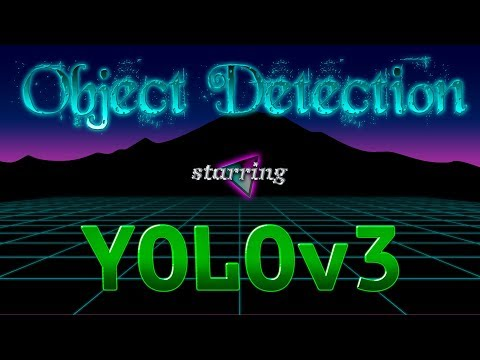

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPU2HistivI', width=600, height=400)

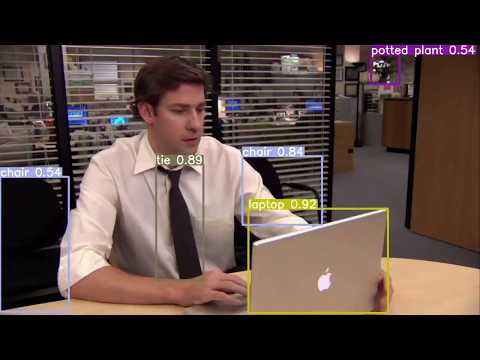

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('XeRJ949qr5c', width=600, height=400)

깨알 질문 Q. 왜 YOLO를 사용할까요?

# Convolution & Pooling
<a id="p1"></a>

신경망 자체와 마찬가지로 CNN은 생물학, 특히 고양이의 시각 피질의 수용 영역(receptive field)에서 영감을 받았습니다.

실제 뇌에서 시각 피질의 뉴런은 특정 영역, 모양, 색상, 방향 및 기타 일반적인 시각적 특징을 수용하도록 영역별로 전문화가 이루어집니다. 어떤 의미에서인지 시스템의 구조 자체가 원시 시각 입력을 변환하여 특정 하위 집합을 처리하는 데 특화된 뉴런으로 보냅니다.

CNN은 컨볼루션(Convolution)을 적용하여 시각적 접근 방식을 모방합니다. 컨볼루션은 한 함수가 다른 함수를 수정하는 방법을 보여주는 세 번째 함수를 생성하는 두 함수에 대한 연산입니다. 컨볼루션에는 교환 성, 연관성, 분배 성 등 다양한 수학적 속성이 있습니다. 컨볼루션을 적용하면 입력의 "모양(shape)"이 효과적으로 변환됩니다.

"컨볼 루션"이라는 용어는 세 번째 공동 함수(Weight Sharing)를 계산하는 프로세스와이를 적용하는 프로세스를 모두 지칭하는 데 사용됩니다. 우리의 맥락에서, 실제 동물의 시야에서 피질의 수용 영역으로의 매핑과 느슨하게 유사한 애플리케이션으로 생각하는 것이 더 유용합니다.

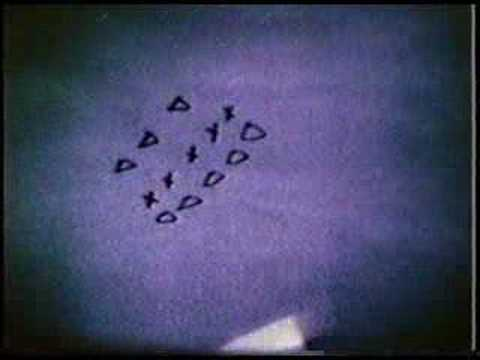

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('Cw5PKV9Rj3o', width=600, height=400)

## 수학적인 이해

### 1D - convolution

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN1.png" width = 600/>

In [ ]:
import numpy as np
input = [0, 0, 26, 51, 58, 59, 53, 29, 0, 0, 0]
patch = [-1, 2, -1]

output = np.convolve(input, patch)
print(output)

[  0   0 -26   1  18   6   7  18   5 -29   0   0   0]


### 2D - Convolution

- convolution

이미지의 노란색 부분으로 변하는 부분이 Convolution filter와 만나는 부분입니다. 그렇게 연산이 되었을 때, 분홍색의 output 값을 얻을 수 있습니다. 

<img src="https://cdn-images-1.medium.com/max/800/1*MrGSULUtkXc0Ou07QouV8A.gif"/>
<br>
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN2.png" width=600>

- padding
 흰 색 pixel의 경우는 실제 이미지가 있는 부분이고, 짙은 회색의 pixel은 feature map의 크기 조절과 데이터를 충분히 활용하기 위해 가장자리에 '0'을 더해준 것입니다. 이런 방식을 zero-padding 이라고 합니다. 

![](https://lambdaschool-data-science.s3.amazonaws.com/images/Unit4/Sprint2/Module2/Screen+Shot+2020-02-25+at+10.27.17+AM.png)

*Image Credits from __Hands on Machine Learning with Sckit-Learn, Keras & TensorFlow__*

- Stride = 1

 성큼성큼 걷다는 표현의 단어 뜻을 가지고 있습니다. 한번에 얼만큼씩 걸을 것인지, 나타내는 의미입니다. stride가 1일 때는 한걸음씩, 2일 때는 두걸음씩 걸어가면서 연산을 한다는 것입니다. 그림을 보면 조금 더 쉽게 이해가 될 것입니다.  주목해야 할 것은 output의 사이즈가 달라진다는 것입니다. Stride를 이용한 Convolution의 경우는 pooling이 자동으로 되는 방식입니다. 이후 GAN에서 해당 방식을 다루게 됩니다.  

<img src="https://adeshpande3.github.io/assets/Stride1.png"/>

- Stride = 2

<img src="https://adeshpande3.github.io/assets/Stride2.png"/>


용어설명:
- __Filter__: 가중치 (weights parameters)의 집합으로 이루어져 가장 작은 특징을 잡아내는 창
- __Stride__: 필터(filter)를 얼만큼씩 움직이며 이미지를 볼 지 결정하는 수 (예) Stride가 1이면 한칸씩 이동하며, 누락없이 모든것을 본다면, stride가 2 이면 한칸씩 건너뛰면서 Filter를 적용하게 되고, 띈 만큼 다음 레이어의 데이터의 수가 줄어듭니다. 
- __Padding__: Zeros(또는 다른 값)을 이미지의 외각(가장자리)에 배치하여 conv를 할 때 원래 이미지와 같은 데이터의 수를 갖을 수 있도록 도와줌 (Stride = 1일 때)

In [ ]:
# Conv2D함수 정의
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

<img src="https://miro.medium.com/max/660/1*V5ZIZg7cGHLASKbnRbKBJQ.png">

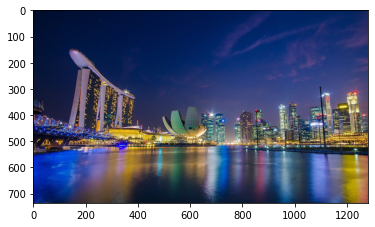

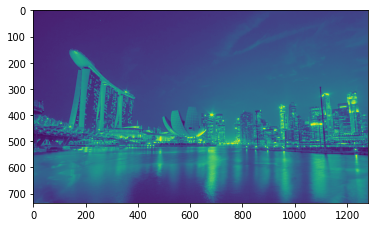

In [ ]:
import sys
import requests
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Grayscale Image
response = requests.get("https://cdn.pixabay.com/photo/2017/08/31/09/40/singapore-2699987_1280.jpg")
img = Image.open(BytesIO(response.content))
open_cv_image = np.array(img) 
open_cv_image = cv2.cvtColor(src=open_cv_image, code=cv2.COLOR_BGR2GRAY)

imgplot = plt.imshow(img)
plt.show() # original image
imgplot = plt.imshow(open_cv_image)
plt.show() # transformed image


In [ ]:
# Edge Detection Kernel
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

# Convolve and Save Output
output = convolve2D(open_cv_image, kernel, padding=1)
cv2.imwrite('2DConvolved.jpg', output)

True

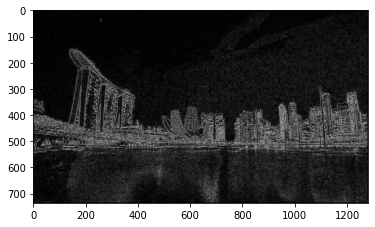

In [ ]:
im = cv2.imread('2DConvolved.jpg')
imgplot = plt.imshow(im)
plt.show()

---

### Example

In [ ]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity

check = io.imread('https://assets.burberry.com/is/image/Burberryltd/0A0E4068-B7AE-4753-A989-EAD870D22DAA.jpg?$BBY_V2_ML_3x4$&wid=1278&hei=1700')
check_grayscale = rescale_intensity(color.rgb2gray(check))
check_grayscale.shape

(1700, 1278)

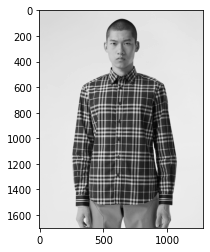

In [ ]:
plt.imshow(check_grayscale, cmap="gray");

In [ ]:
check_grayscale.shape

(1700, 1278)

In [ ]:
import numpy as np
import scipy.ndimage as nd

horizontal_edge_convolution = np.array([[1,1,1,1,],
                                        [0,0,0,0],
                                        [0,0,0,0],
                                        [-1,-1,-1,-1]])

vertical_edge_convolution = np.array([[1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1]])

check_edges_vert = nd.convolve(check_grayscale, vertical_edge_convolution, mode='constant', cval=0.0)
check_edges_horz = nd.convolve(check_grayscale, horizontal_edge_convolution, mode='reflect')
print(check_edges_vert.shape)
print(check_edges_horz.shape)

(1700, 1278)
(1700, 1278)


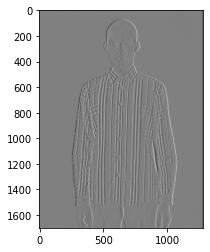

In [ ]:
plt.imshow(check_edges_vert, cmap="gray");

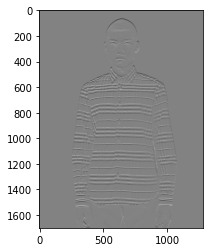

In [ ]:
plt.imshow(check_edges_horz, cmap="gray");

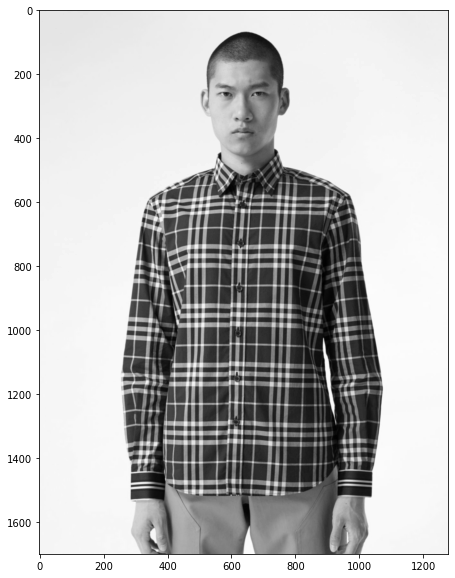

In [ ]:
ones_convolution = np.array([[1, 1, 1],
                              [1, 1, 1],
                              [1, 1, 1]])
check_ones = nd.convolve(check_grayscale, ones_convolution)
plt.figure(figsize=(30,10))
plt.imshow(check_ones, cmap="gray")

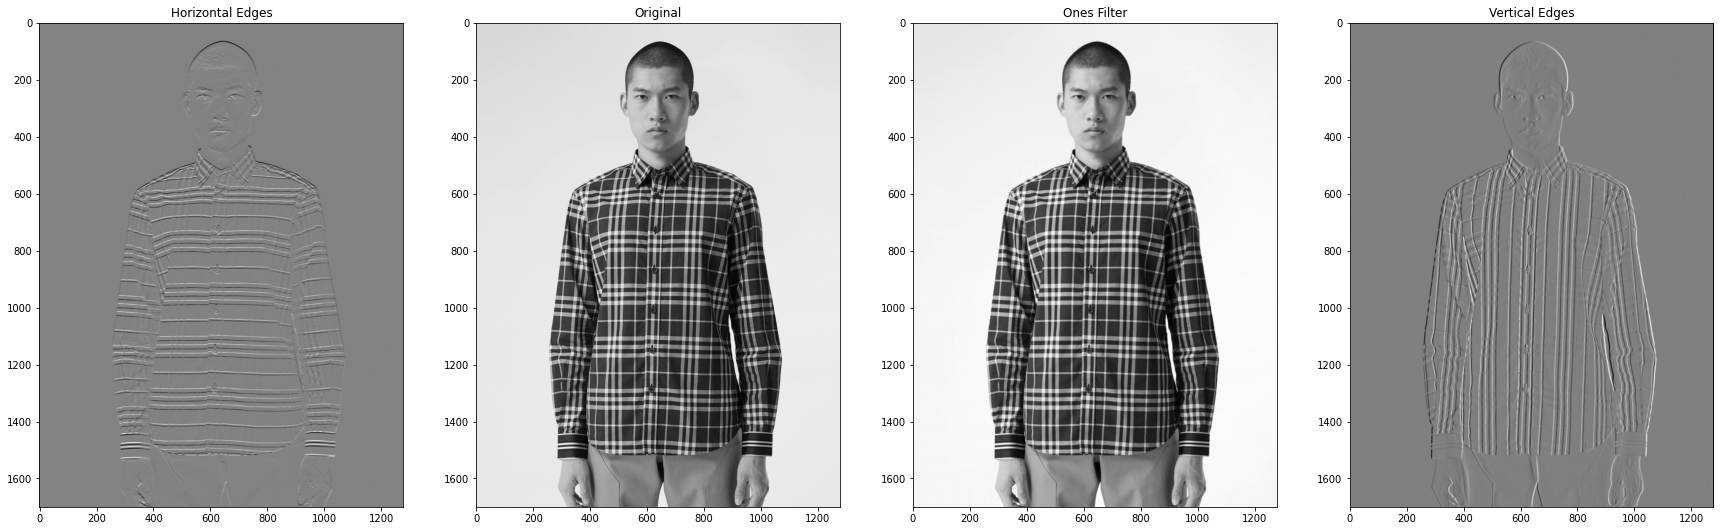

In [ ]:
plt.figure(figsize=(30,10))

labels = ["Horizontal Edges", "Original", "Ones Filter", "Vertical Edges"]
images = [check_edges_horz, check_grayscale, check_ones, check_edges_vert]

i = 0
for label, image in zip(labels, images):

    plt.subplot(1,4,i+1)
    plt.grid(False)
    plt.imshow(image, cmap="gray")
    plt.title(label)
    i += 1 

plt.show()

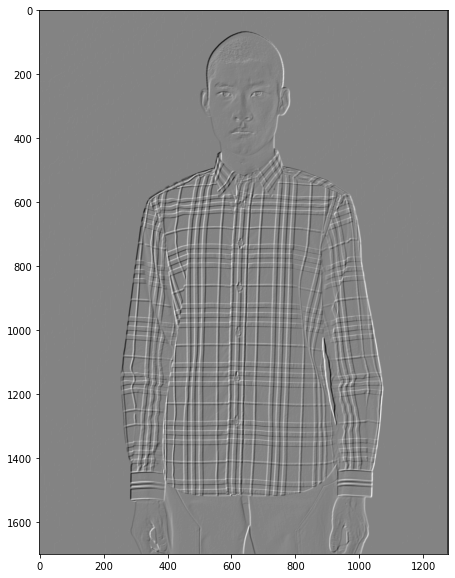

In [ ]:
# combine vertical and horizontal edges
combined = check_edges_horz + check_edges_vert
plt.figure(figsize=(30,10))
plt.imshow(combined, cmap="gray")

ImageNet으로 학습이 다 되었을 때 필터의 역할(1st Layer의 Weight 표현)

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN3.png" width = 800/>

### Pooling Layer

![](https://lambdaschool-data-science.s3.amazonaws.com/images/Unit4/Sprint2/Module2/Screen+Shot+2020-02-25+at+10.26.13+AM.png)

*Image Credits from __Hands on Machine Learning with Sckit-Learn, Keras & TensorFlow__*

풀링 레이어를 사용하여 피처맵의 차원을 줄입니다. 보통 컨볼루션을 적용한 이후 레이어를 풀링하여 점점 더 작은 피쳐맵를 얻습니다. 이렇게 줄어든 피쳐들을 이용하여 ANN형태의 신경망에 넣어 Classification or regression을 수행하게 됩니다. 

Austen의 사진을 사용하여 매우 간단한 예를 살펴 보겠습니다.

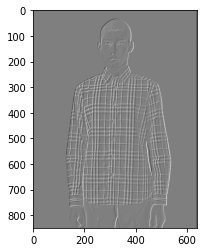

In [ ]:
from skimage.measure import block_reduce

reduced = block_reduce(combined, (2,2), np.max)
plt.imshow(reduced, cmap="gray");

In [ ]:
reduced.shape

(850, 639)

이렇게 CNN의 특징을 잡아내는 방식에 대해서 살펴보았습니다. <br>
패치와 같은 형태로 특징을 잡아내기 때문에 얻어질 수 있는 장점을 간단히 생각해보면, 
- local Feature : 지역적 특징을 잡아 냄
- weight sharing
- translation invariance : 어느정도 움직임이 있더라도 해석이 큰 무리가 없다.


# CNN 분류기

### 전형적인 CNN Architecture

[틀린그림찾기]
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png" width=700/>

CNN의 첫 번째 단계는 당연히 convolution입니다. 특히 입력 이미지의 영역을 수신을 담당하는 뉴런에 매핑하는 변환입니다. 컨벌루션 레이어는 다음과 같이 시각화 할 수 있습니다.
<br>
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN7.png" width=300/>
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN8.png" width=300/>

빨간 박스는 원래 입력 이미지를 나타내고 파란색은 해당하는 네트워크의 뉴런을 나타냅니다. 속 안에 있는 작은 박스는 선택된 영역이 어떤 과정을 거쳐서 처리가 되는지 볼 수 있습니다. 여러가지 필터를 통과해서 하나의 이미지가 여러개의 특징으로 나눠진 것을 볼 수 있습니다. (receptive field라고 수용영역을 나타냅니다.)

첫 번째 이미지에서 볼 수 있듯이 CNN은 여러 라운드의 컨볼루션, 풀링 (필터를 통과하여 정보를 효과적으로 줄이는 디지털 신호 처리 기술), 그리고 결국에는 완전히 연결된 신경망과 출력 레이어를 가질 수 있습니다. CNN의 일반적인 출력 계층은 분류 또는 감지 문제를 지향합니다. "이 사진에 고양이, 개 또는 다른 동물이 포함되어 있습니까?"


#### A Convolution in Action
<img src="https://miro.medium.com/max/1170/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width=700/>


<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width=700/>






CNN이 왜 그렇게 인기가 있습니까?

WarmUp 영상에서 보셨듯이, 이미지 분류의 큰 획을 그었던 방법론입니다. 

1. 이전 이미지 학습 기술에 비해 이미지 전처리 (자르기 / 센터링, 정규화 등)가 상대적으로 거의 필요하지 않습니다.
2. 이와 관련하여 이미지의 모든 종류의 일반적인 문제 (이동, 조명 등)에 대해 * 견고 함 *

실제로 최첨단 이미지 분류 CNN을 훈련하는 것은 계산적으로 중요하지 않습니다. 

좋은 소식은 전이 학습을 통해 "기성품"을 만들어 사용할 수 있다는 것입니다!

### 다른 네트워크 표현방식(그림)

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN4.png" width=700/>

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN5.png" width=700/>

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/etc/note431/CNN6.png" width=700/>



## 실습 - Cifar 10

In [ ]:
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 4s 0us/step


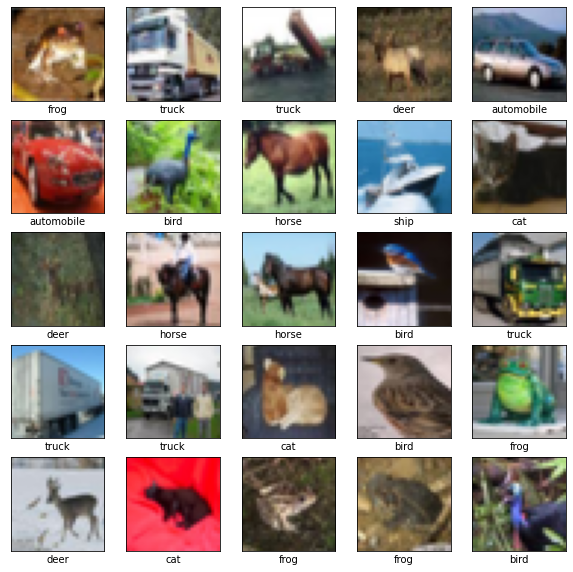

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
train_images[0].shape

(32, 32, 3)

In [ ]:
train_labels[1]

array([9], dtype=uint8)

In [ ]:
32*32*3

3072

In [ ]:
# Setup Architecture
# 기존 신경망과 달리 Dense 대신에 Conv2가 생기신 것을 볼 수 있습니다. 
# 풀링 레이어와 마지막에는 Dense인 일반 신경망이 또 등장합니다.
model = Sequential() ## 과제시에는 이 모델을 Tre-trained model로 대체하면 됩니다. 
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [ ]:
# 모델학습방식을 정의함
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 모델 학습시키기
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 12s 3ms/step - loss: 1.7318 - accuracy: 0.3630 - val_loss: 1.2294 - val_accuracy: 0.5618
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1653 - accuracy: 0.5860 - val_loss: 1.0685 - val_accuracy: 0.6200
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9876 - accuracy: 0.6560 - val_loss: 1.0076 - val_accuracy: 0.6492
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8884 - accuracy: 0.6864 - val_loss: 1.0206 - val_accuracy: 0.6505
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8155 - accuracy: 0.7146 - val_loss: 0.8768 - val_accuracy: 0.6980
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7370 - accuracy: 0.7401 - val_loss: 0.8877 - val_accuracy: 0.6925
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6955 - accuracy: 0.7557 - val_loss: 0.8666 - val_accuracy

In [ ]:
# 수행
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 0s - loss: 0.9293 - accuracy: 0.6949


# 전이학습 (Transfer Learning)

<img src="https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png"/>

"기존(내 목적과는 다른) 데이터로 학습된 **네트워크를 재사용** 가능하도록하는 라이브러리"입니다.

  이를 통해 수천 시간의 GPU로 학습된 모델을 다운받아 내 작업에 활용할 수 있습니다. 학습되었다는 것은 가중치(Weights)와 편향(bias)이 포함된 학습된 모델의 일부를 재사용하기에 Transfer learning 이라고 표현합니다. 위 그림처럼 일부만 사용을 해서 활용할 수 도 있지만, 전체를 다 재학습할 수도 있습니다. **교육 데이터를 적게 사용**하고, **교육 속도가 빠르며, 더 잘 일반화하는 모델**을 가질 수 있습니다.


사용하는 방법은 다음과 같습니다
1. 이전에 학습한 모델에서 **파라미터를 포함한 레이어**를 가져옵니다.
2. 향후 교육 과정 중에 포함된 정보가 손상되지 않도록 해당 정보를 동결(freeze, 가중치를 업데이트 하지 않음)합니다.
3. 동결된 층 위에 새로운 층 (학습 가능한 층)을 더합니다. 
  * **출력층(output)의 수를 조절**하여 새로운 데이터셋에서 원하는 예측방법(분류, 회귀 등)으로 전환하는 방법을 배울 수 있게됩니다.
4. 새로운 데이터셋에서 **새로 추가한 계층만을 학습**합니다.
  * 만약 기존 레이어를 동결하지 않으면, 학습된 레이어에서 가져온 weight까지 학습하게 됩니다. 
  * 위 경우 학습할 것이 많아지므로 시간이 오래걸립니다.

> 중요한 벤치마크 모델을 적절하게 선택할 수 있습니다. 이미지 분류기 ResNet50를 기준으로 배워보겠습니다. ResNet은 CNN의 일종인데, 기존의 Squential 모델과 달리 skipped connection이 있는 모델입니다. 이 연결을 통해서 더 깊은 층 만들더라도 학습이 가능해집니다. 

<img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png" width=400/>


In [ ]:
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

# 클래스의 개수 정의 : Cats & Dogs 
NUM_CLASSES = 2

# 입력 이미지의 차원 수 : RGB
CHANNELS = 3
# 학습된 네트워크 특징
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# 출력 Metric
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# 테스트 배치의 개수
BATCH_SIZE_TESTING = 1

In [ ]:
# 모델 제작
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
# weights = resnet_weights_path 학습해둔 모델이 있으면 이렇게 불러올 수 있음
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE)) 
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# 이미 학습된 영역은 학습하지 않겠다고 설정하는 옵션 
model.layers[0].trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# 모델 구조
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

# optimizer, compile
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# 입력 이미지 사이즈 정의
image_size = IMAGE_RESIZE
# 입력 이미지, 데이터 증량(Augmentation)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_images)

#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
# 모델 학습 (전이 학습)
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32, epochs=NUM_EPOCHS)

Epoch 1/10
1562/1562 [==============================] - 34s 20ms/step - loss: 1277.1084 - accuracy: 0.5007
Epoch 2/10
1562/1562 [==============================] - 31s 20ms/step - loss: 1272.0334 - accuracy: 0.4977
Epoch 3/10
1562/1562 [==============================] - 32s 20ms/step - loss: 1272.9566 - accuracy: 0.4999
Epoch 4/10
1562/1562 [==============================] - 32s 20ms/step - loss: 1195.1576 - accuracy: 0.4978
Epoch 5/10
1562/1562 [==============================] - 32s 20ms/step - loss: 978.6157 - accuracy: 0.5014
Epoch 6/10
1562/1562 [==============================] - 31s 20ms/step - loss: 960.8744 - accuracy: 0.4985
Epoch 7/10
1562/1562 [==============================] - 31s 20ms/step - loss: 972.5264 - accuracy: 0.5013
Epoch 8/10
1562/1562 [==============================] - 31s 20ms/step - loss: 967.3133 - accuracy: 0.4989
Epoch 9/10
1562/1562 [==============================] - 31s 20ms/step - loss: 966.5294 - accuracy: 0.5015
Epoch 10/10
1562/1562 [===================

[keras에서 제공하는 Transfer learning](https://colab.research.google.com/github/keras-team/keras-io/blob/master/guides/ipynb/transfer_learning.ipynb#scrollTo=889vfyeqUmQ7)

# Review

- Part 1: </a> CNN의 핵심개념인 convolution과 pooling 구조를 이해합니다.
    * 컨볼루션(Convolution)은 필터개념의 새로운 함수를 생성하여 연산하고 다음 레이어로 전달하는 가중치를 새롭게 만들어줍니다. 
    * 컨볼루션은 커널(가중치 모음, 필터)은 CNN을 학습하는 과정에서 '학습'됩니다.
    * 풀링(Pooling)은 데이터를 다운 샘플링하기 위해 피쳐 맵 영역의 최대 또는 평균을 사용하는 차원 감소 기술입니다.
- Part 2: </a> CNN을 classification task에 적용해본다.
    * Keras를 사용하여 모델 학습하고 사용하는 과정을 배운다. 
- Part 3: Transfer learning
    * Fine tuning 개념을 이해
    * 학습 동결의 개념과 동결하는 코드를 이해
    * 여러가지 모델들을 불러와서 재사용


# Sources

- *_Deep Learning_*. Goodfellow *et al.*
- *Hands-on Machine Learnign with Scikit-Learn, Keras & Tensorflow*
- [Keras CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn)
- [Tensorflow + Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [Convolution Wiki](https://en.wikipedia.org/wiki/Convolution)
- [Keras Conv2D: Working with CNN 2D Convolutions in Keras](https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/)
- [Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)
- [A Beginner's Guide to Understanding Convolutional Neural Networks Part 2](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)
- [Keras Transfer Learning Tutorial](https://keras.io/guides/transfer_learning/)